### Importing Library and Dataset

In [1]:
# System
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Neural Network and Deep Learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

In [2]:
# Load the dataset
data = pd.read_csv('sleeptime_prediction_dataset.csv')

# Display the first few rows of the dataset
print(data.head())

   WorkoutTime  ReadingTime  PhoneTime  WorkHours  CaffeineIntake  \
0         1.12         0.52       3.29       7.89          216.08   
1         2.85         0.49       4.22       5.03          206.18   
2         2.20         1.81       4.04       9.23           28.73   
3         1.80         0.50       1.62       7.68          276.77   
4         0.47         0.54       1.60       4.94          170.54   

   RelaxationTime  SleepTime  
0            0.75       3.45  
1            0.67       4.88  
2            0.35       3.61  
3            1.21       4.94  
4            0.95       5.50  


### Custom RBF Layer

In [3]:
# Custom RBF Layer
class RBFLayer(Layer):
    def __init__(self, num_centers, **kwargs):
        self.num_centers = num_centers
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Initialize centers and widths
        self.centers = self.add_weight(name='centers',
                                       shape=(self.num_centers, input_shape[1]),
                                       initializer='random_normal',
                                       trainable=True)
        self.widths = self.add_weight(name='widths',
                                      shape=(self.num_centers,),
                                      initializer='ones',
                                      trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute the RBF output
        dists = K.sqrt(K.sum(K.square(K.expand_dims(inputs, 1) - self.centers), axis=-1))
        return K.exp(-K.square(dists) / (2 * K.square(self.widths)))

### EDA: Overview

In [4]:
# Display summary statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
WorkoutTime,2000.0,1.495915,0.876639,0.01,0.71,1.520,2.2500,3.00
ReadingTime,2000.0,0.992785,0.577303,0.00,0.50,0.990,1.5000,2.00
PhoneTime,2000.0,2.985195,1.151776,1.00,1.99,2.965,3.9600,5.00
WorkHours,2000.0,6.926945,1.723843,4.00,5.44,6.910,8.4225,10.00
CaffeineIntake,2000.0,147.493780,84.651139,0.02,75.98,146.010,218.9025,299.85
RelaxationTime,2000.0,1.010955,0.582619,0.00,0.51,1.010,1.5300,2.00
SleepTime,2000.0,4.884375,2.028892,0.15,3.84,4.600,5.4700,19.81


In [5]:
# Display data types of each column
data.dtypes.T

WorkoutTime       float64
ReadingTime       float64
PhoneTime         float64
WorkHours         float64
CaffeineIntake    float64
RelaxationTime    float64
SleepTime         float64
dtype: object

In [6]:
# Display the shape of the data
data.shape

(2000, 7)

### Data Preprocessing

In [7]:
# Preview NULL values
data.isnull().sum()

WorkoutTime       0
ReadingTime       0
PhoneTime         0
WorkHours         0
CaffeineIntake    0
RelaxationTime    0
SleepTime         0
dtype: int64

In [8]:
# Remove outliers based on a specific condition
data = data[data.iloc[:, 6] < 10]  # Assuming the 7th column is the one to check for outliers

In [9]:
# Assuming 'SleepTime' is the target variable and the rest are features
X = data.drop(columns=['SleepTime']).values  # Features
y = data['SleepTime'].values  # Target variable

# Split data to train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Building

In [ ]:
# Build the RBF model
num_centers = 10  # You can adjust the number of centers
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))  # Input layer
model.add(RBFLayer(num_centers))  # RBF layer
model.add(tf.keras.layers.Dense(1))  # Output layer for regression

# Compile the model
model.compile(loss="mean_squared_error", metrics=['mae'], optimizer='adam')  # Using MSE for regression
model.summary()

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit Model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[early_stopping])  # Reduced epochs

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Make predictions on the training set
y_pred_train = model.predict(X_train)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rbf_layer (RBFLayer)            │ (None, 20)             │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 21.6049 - mae: 4.5135 - val_loss: 20.1577 - val_mae: 4.3339
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.5009 - mae: 4.2695 - val_loss: 18.3468 - val_mae: 4.1160
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.1305 - mae: 4.0996 - val_loss: 16.4454 - val_mae: 3.8715
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1078 - mae: 3.8331 - val_loss: 14.4129 - val_mae: 3.5907
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.5345 - mae: 3.4727 - val_loss: 12.3249 - val_mae: 3.2738
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.7034 - mae: 3.1932 - val_loss: 10.2494 - val_mae: 2.9258
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.0172 - mae: 2.8819 - val_loss: 8.3328 - val_mae: 2.5651
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9466 - mae: 2.5141 - val_loss: 6.6992 - val_mae: 2.2313
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

### Evaluation of Model

In [11]:
# Calculate error metrics for the test set
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print the error metrics for the test set
print(f"Test Set - Mean Absolute Error (MAE): {mae_test}")
print(f"Test Set - Mean Squared Error (MSE): {mse_test}")
print(f"Test Set - R-squared (R²): {r2_test}")

Test Set - Mean Absolute Error (MAE): 0.26303240551668056
Test Set - Mean Squared Error (MSE): 0.3949751188822386
Test Set - R-squared (R²): 0.7102383544866974


In [12]:
# Calculate error metrics for the training set
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Print the error metrics for the training set
print(f"Training Set - Mean Absolute Error (MAE): {mae_train}")
print(f"Training Set - Mean Squared Error (MSE): {mse_train}")
print(f"Training Set - R-squared (R²): {r2_train}")

Training Set - Mean Absolute Error (MAE): 0.23210597390329235
Training Set - Mean Squared Error (MSE): 0.2603402763364938
Training Set - R-squared (R²): 0.7964217339771226


### Visualization of Data

In [ ]:
# Pairplot to visualize relationships between features
sns.pairplot(data)
plt.tight_layout()
plt.show()

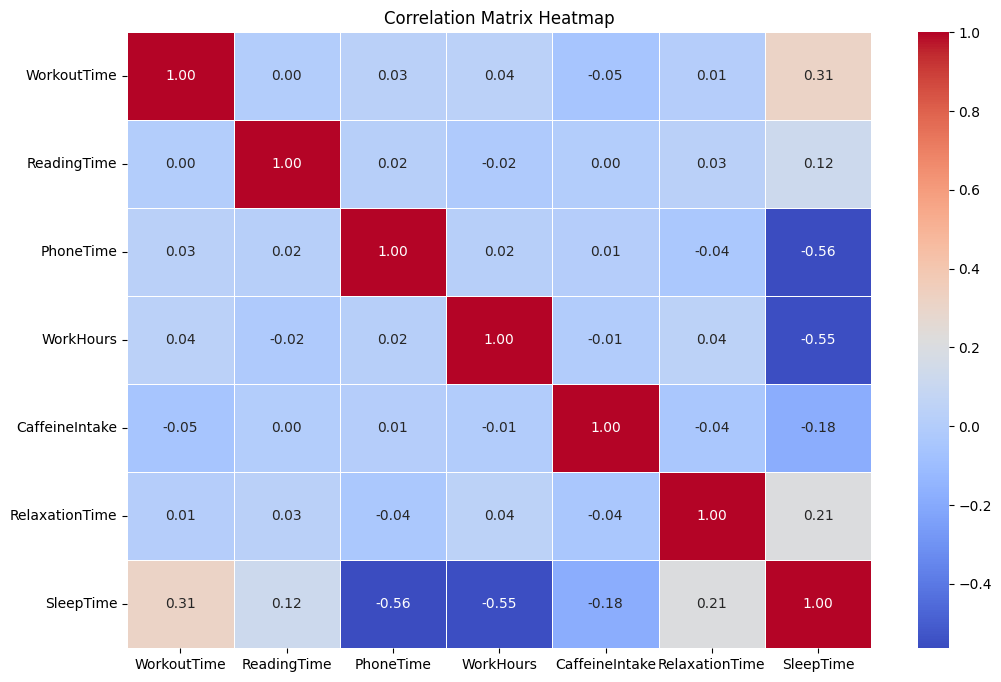

In [15]:
# Correlation matrix heatmap
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

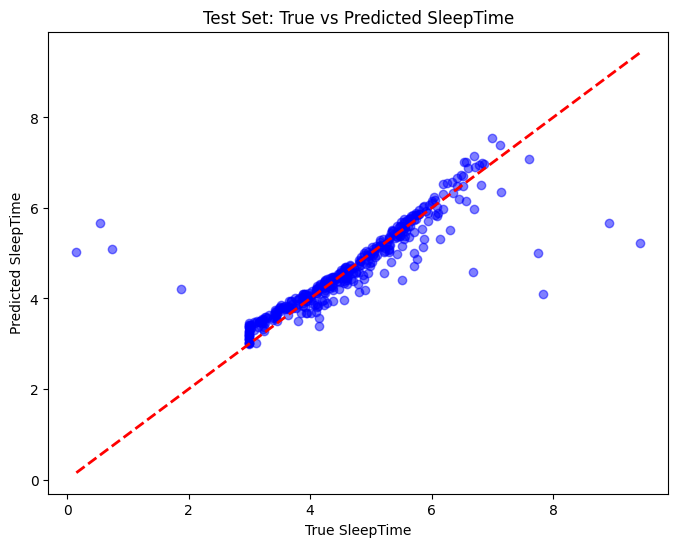

In [16]:
# Scatter plot of True vs Predicted values for the test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Test Set: True vs Predicted SleepTime")
plt.xlabel("True SleepTime")
plt.ylabel("Predicted SleepTime")
plt.show()

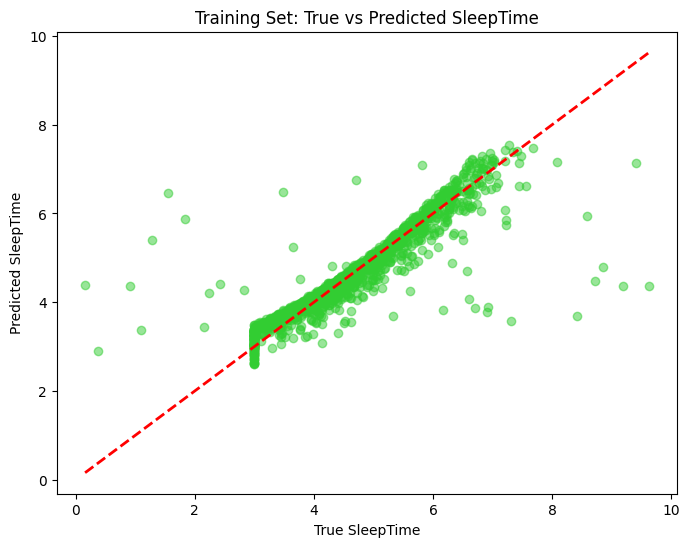

In [17]:
# Scatter plot of True vs Predicted values for the training set
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred_train, alpha=0.5, color='limegreen')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.title("Training Set: True vs Predicted SleepTime")
plt.xlabel("True SleepTime")
plt.ylabel("Predicted SleepTime")
plt.show()